# 빅데이터경영 MBA 이재현 기말 프로젝트

### 주제 : 2015,2016 년도의 딥러닝 키워드를 가진 기사 크롤링 후 두 연도간의 단어 비교
### -- 2016년의 경우 5월 31일까지 기사만 확인
### 기사원문 : ZDNet Korea

In [25]:
import requests  # url 요청에 대한 사이트 내용 가져올 모듈 
import lxml.html # url 요청에 대한 html 형식 처리
import csv # csv 처리
from konlpy.tag import Twitter # 단어 처리
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import operator
import networkx
import math
import pandas as pd
from urllib.parse import quote
from wordcloud import WordCloud
from matplotlib import pyplot
import matplotlib.font_manager # font 관련
%matplotlib inline


In [168]:
def extract(url, path):
    '''xpath 추출 함수'''
    res = requests.get(url)
    res.encoding = 'cp949'
    root = lxml.html.fromstring(res.text)
    # print(root.xpath(path).text_content())
    return root.xpath(path)

def get_word(doc):
    '''길이가 2 이상인 단어만 뽑기'''
    tagger = Twitter()
    nouns = tagger.nouns(doc)
    
    remove_noun = []
    with open('remove_word.txt', 'r', newline='\r\n', encoding='utf8') as f:
        for line in f.readlines():
            remove_noun.append(line.strip())
            
    res = []
    for noun in nouns:
        if ((len(noun) > 1) & (noun not in remove_noun)) :
            res.append(noun)
    
    return res

def get_last_page(url):
    ''' 마지막 페이지를 불러오는 함수'''
    res_num = requests.get(url)
    num_root = lxml.html.fromstring(res_num.text)
    count = num_root.xpath('.//span[@class="result_num"]/text()')
    tmp = count[0].replace("\r",'').replace("\n",'').replace("\t",'') # 전체 건수 뽑기
    return math.ceil(int((tmp.split(' / ')[1].split('건')[0]).replace(',','')) / 10) # 10 : 페이지당 기사건수

##### 시작할 때 기사 조회기간 입력(현재 주제는 2015년이므로 2015-01-01 ~ 2015-12-31 까지만 입력)

In [192]:
start_date = input("시작 일자를 입력하세요(형식 : YYYY-MM-DD) : ")
end_date = input("끝 일자를 입력하세요(형식 : YYYY-MM-DD) : ")
query_string = input("검색어를 입력하세요 :")

시작 일자를 입력하세요(형식 : YYYY-MM-DD) : 2016-01-01
끝 일자를 입력하세요(형식 : YYYY-MM-DD) : 2016-05-31
검색어를 입력하세요 :딥러닝


In [193]:
# 검색어 날짜 처리
remove_slash_start = start_date.replace("-", "")
remove_slash_end = end_date.replace("-","")

In [194]:
# 검색어 encoding 확인
print (quote(query_string.encode('euckr')))

url1 = 'http://news.naver.com/main/search/search.nhn?query='
encode_url = quote(query_string.encode('euckr'))+'&st=news.all&q_enc=EUC-KR&r_enc=UTF-8'
url2 = '&r_format=xml&rp=none&sm=all.basic&ic=all&so=rel.dsc&rcnews=exist:092:&rcsection=exist'
range_url = ':&stDate=range:'+remove_slash_start+':'+remove_slash_end 
url3 = '&detail=0&pd=4&r_cluster2_start=1&r_cluster2_display=10&start=1&display=5&'
date_url = 'startDate='+start_date+'&endDate='+end_date

url = url1+encode_url+url2+range_url+url3+date_url

page_str = "&page={}"
article_xpath = './/a[@class="go_naver"]'
filename = 'naver_news_'+query_string+'_'+remove_slash_end+'.csv'
print (url)

%B5%F6%B7%AF%B4%D7
http://news.naver.com/main/search/search.nhn?query=%B5%F6%B7%AF%B4%D7&st=news.all&q_enc=EUC-KR&r_enc=UTF-8&r_format=xml&rp=none&sm=all.basic&ic=all&so=rel.dsc&rcnews=exist:092:&rcsection=exist:&stDate=range:20160101:20160531&detail=0&pd=4&r_cluster2_start=1&r_cluster2_display=10&start=1&display=5&startDate=2016-01-01&endDate=2016-05-31


In [195]:
### 뉴스 저장
err_url = []

with open(filename, 'w', encoding = 'utf8') as f:
    writer = csv.writer(f)
    last_page = get_last_page(url)
    # print (last_page)
    for page in range(1,last_page+1):
        page_url = url+page_str.format(page)
        
        for node in extract(page_url, article_xpath):
            try:                
                title = node.text_content()
                content_url = node.attrib['href']
                # content_url = 'http://www.zdnet.co.kr/column/column_view.asp?artice_id=20141222090229&type=det&re='
                print(title, content_url)
                post_content = extract(content_url, './/div[@id="articleBodyContents"]')[0]    
                writer.writerow([post_content.text_content()])
            except:
                print("error")
                break

네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002097362
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002097348
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002095123
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002093787
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002092232
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002097237
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002093143
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=103&oid=092&aid=0002096651
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002096224
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002095937
네이버뉴스 http://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002095897

# 뉴스읽기

In [196]:
### 뉴스 읽기
news = []
with open(filename, 'r', newline='\r\n', encoding='utf8') as f:
    reader = csv.reader(f)
    for row in reader:
        news.append(row[0])

# Term-Document Matrix 

In [197]:
def words_count(news) :    
    '''분석된 단어와 단어의 빈도수 가져오는 함수'''
    ### 형태소 분석기
    tagger = Twitter()
    cv = CountVectorizer(tokenizer=tagger.nouns, max_features=50)
    tdf = cv.fit_transform(news)
    
    ### 한단어 빼기 
    cv = CountVectorizer(tokenizer=get_word, max_features=50)
    tdf = cv.fit_transform(news)
    words = cv.get_feature_names()
    print (words)
    
    count_mat = tdf.sum(axis=0) # 열별로 단어별 출현 빈도 합계 구함(axis = 1 , 각 문서별 명사의 사용 개수)
    count = np.squeeze(np.asarray(count_mat)) # 대괄호가 하나로 줄어듬. 좀더 데이터 핸들링을 쉽게 하기 위해 리스트 형태로 해줌
    print (count)
    
    return words, count, tdf

In [198]:
words , count, tdf = words_count(news)

['계산', '고가', '고의', '과제', '구글', '기술', '네이버', '능력', '대결', '대국', '데이터', '러닝', '로봇', '머신', '모바일', '바둑', '박사', '번역', '보안', '분석', '빅데이터', '사고', '스타트업', '시스템', '아직', '알고리즘', '알파', '엔비디아', '연구소', '오픈소스', '왓슨', '의료', '이미지', '이세돌', '인간', '인식', '자동', '자율', '정보기술', '주행', '지식', '카카오', '컴퓨터', '컴퓨팅', '클라우드', '패러데이', '페이스북', '퓨처', '프로젝트', '학습']
[ 28  23  32  25 144 294  72  33  23  69 122 262  27  93  29  97  32  21
  38  70  40  22  28  54  24  64 180  25  40  25  23  26  59  84  49  31
  22  63  27  66  29  27  38  28  26  25  42  25  29  58]


##### graph에 한글 표시를 위한 코드

In [199]:
print ([f.name for f in matplotlib.font_manager.fontManager.ttflist])  # 그래프에 한글 표시를 위한 코드
matplotlib.rc('font', family='HCR Dotum') # font 지정

['Bitstream Vera Serif', 'STIXGeneral', 'STIXGeneral', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'STIXSizeTwoSym', 'STIXSizeThreeSym', 'cmex10', 'Bitstream Vera Sans Mono', 'STIXSizeOneSym', 'Bitstream Vera Sans', 'Bitstream Vera Serif', 'STIXSizeFiveSym', 'cmr10', 'STIXGeneral', 'Bitstream Vera Sans Mono', 'STIXSizeFourSym', 'Bitstream Vera Sans', 'STIXNonUnicode', 'cmmi10', 'cmb10', 'Bitstream Vera Sans Mono', 'STIXNonUnicode', 'Bitstream Vera Sans', 'cmss10', 'Bitstream Vera Sans Mono', 'cmtt10', 'Bitstream Vera Sans', 'cmsy10', 'STIXNonUnicode', 'STIXSizeOneSym', 'STIXSizeFourSym', 'STIXGeneral', 'STIXNonUnicode', 'Vivaldi', 'ParkAvenue BT', 'Garamond', 'Traditional Arabic', 'Yj TEUNTEUN Bold', 'Haan Cooljazz M', 'Comic Sans MS', 'Century Schoolbook', 'Trebuchet MS', 'EucrosiaUPC', 'Microsoft New Tai Lue', 'Calibri', '??????', 'EucrosiaUPC', 'HYsupB', 'Aparajita', 'SimSun-ExtB', 'Angsana New', 'JasmineUPC', 'Elephant', 'Stencil', 'Haan YHead B', 'Arabic Typesetting', 'Brush Script MT',

##### DataFrame 생성 후 단어별 빈도수 확인

In [200]:
word_data = {'word' : words, 'count' : count}

In [201]:
word_df = pd.DataFrame(word_data, columns =['word', 'count'] )

In [202]:
word_df

,word,count
0,계산,28
1,고가,23
2,고의,32
3,과제,25
4,구글,144
5,기술,294
6,네이버,72
7,능력,33
8,대결,23
9,대국,69


In [203]:
group_word = word_df.groupby('word').agg({'count': sum})

In [204]:
group_word = group_word.sort_values(['count'], ascending=[0])

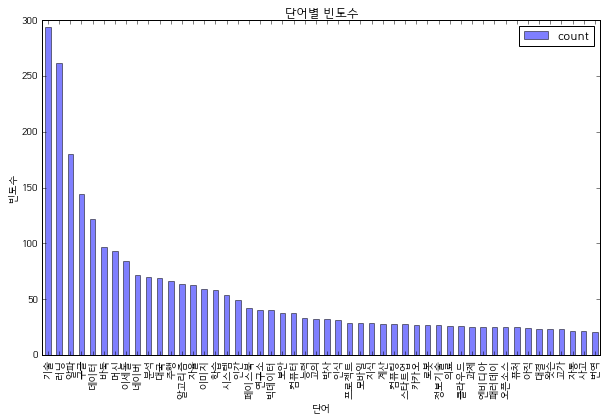

In [205]:
group_word.plot(kind="bar", alpha=0.5, rot=90, figsize=(10, 6), color = "blue")
pyplot.xlabel("단어")
pyplot.ylabel("빈도수")
pyplot.title("단어별 빈도수")
pyplot.savefig(query_string+'_'+remove_slash_end+'_'+'_barplot.png')
pyplot.show()

### wordcloud

In [206]:
def draw_wordcloud(words, count, file_nm, end):
    '''wordcloud 그래프 그리는 함수'''
    word_count = list(zip(words, count)) # zip : 두개의 각 리스트별 원소의 짝을 지어줌
    ## 빈도수 정렬
    sorted(word_count, key=operator.itemgetter(1), reverse=True) # word_count를 1번째(빈도수)를 기준으로 내림차순 정렬을 하라
    ## 워드 클라우드 
    wc = WordCloud(font_path='C:\\Windows\\Fonts\\malgun.ttf', background_color='white', width=400, height=300)
    cloud = wc.generate_from_frequencies(word_count)

    pyplot.figure(figsize=(12, 9))
    pyplot.imshow(cloud)
    pyplot.axis("off")    
    pyplot.savefig(file_nm+'_'+end+'_wordcloud.png')
    pyplot.show()

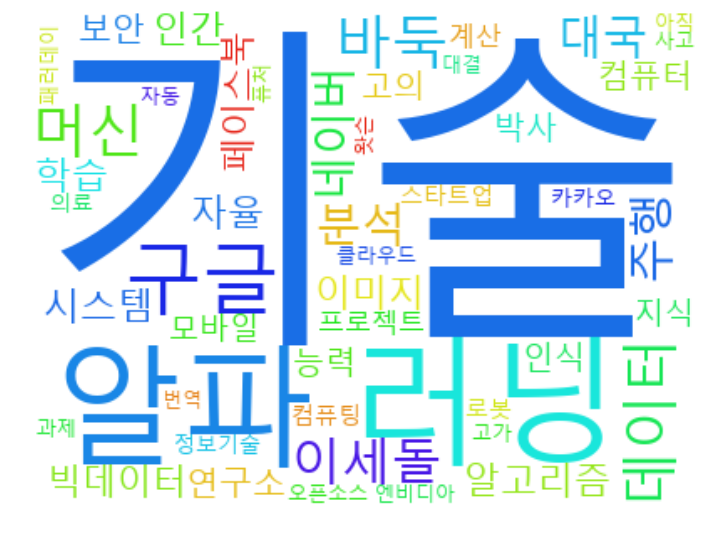

In [207]:
draw_wordcloud(words,count,query_string, remove_slash_end)

In [208]:
word_corr = np.corrcoef(tdf.todense(), rowvar=0) # 상관계수 구하기(rowvar =0 : 컬럼단위 상관계수, 1이면 문서간의 상관계수)
print (word_corr)

[[ 1.          0.56466102  0.18467513 ..., -0.04138174 -0.1250468
   0.10616961]
 [ 0.56466102  1.          0.36553544 ..., -0.06499432 -0.06973586
   0.20300046]
 [ 0.18467513  0.36553544  1.         ..., -0.05612066 -0.19784879
   0.16535663]
 ..., 
 [-0.04138174 -0.06499432 -0.05612066 ...,  1.          0.06184944
  -0.07876888]
 [-0.1250468  -0.06973586 -0.19784879 ...,  0.06184944  1.         -0.03830251]
 [ 0.10616961  0.20300046  0.16535663 ..., -0.07876888 -0.03830251  1.        ]]


In [209]:
def get_corr_data(words, word_corr, tdf):
    '''단어간의 상관계수를 구하는 함수'''
    edges = []
    for i in range(len(words)): 
        for j in range(i + 1, len(words)): 
            edges.append((words[i], words[j], word_corr[i, j])) # 1이 아닌 및부분의 상관계수 추리기

    edges = sorted(edges, key=operator.itemgetter(2), reverse=True) # 상관게수가 높은걸로 정렬
    edges = edges[:50]
    print (edges)

    edge_list = [(word1, word2) for word1, word2, weight in edges]
    weight_list = [weight for word1, word2, weight in edges]

    return edges, edge_list, weight_list

In [210]:
edges, edge_list, weight_list = get_corr_data(words, word_corr, tdf)

[('패러데이', '퓨처', 1.0), ('자율', '주행', 0.99280514097777028), ('박사', '패러데이', 0.98296219423452236), ('박사', '퓨처', 0.98296219423452236), ('대국', '이세돌', 0.88576594177802348), ('알파', '이세돌', 0.88345477614937118), ('대국', '알파', 0.76246873113593128), ('고의', '이세돌', 0.76210212670868871), ('엔비디아', '패러데이', 0.75785098780525784), ('엔비디아', '퓨처', 0.75785098780525784), ('고의', '알파', 0.75192852012390321), ('네이버', '모바일', 0.74312317890494817), ('박사', '엔비디아', 0.7341082104031581), ('고가', '알파', 0.72441362962526523), ('러닝', '머신', 0.72346020990408211), ('고의', '인간', 0.72163882271489543), ('컴퓨팅', '클라우드', 0.71237121896512601), ('고가', '이세돌', 0.70194828470387649), ('왓슨', '지식', 0.69851901671860617), ('데이터', '분석', 0.67857886845993898), ('능력', '인간', 0.6767663221855944), ('자율', '패러데이', 0.66046257579018786), ('자율', '퓨처', 0.66046257579018786), ('아직', '정보기술', 0.65916459066881283), ('구글', '페이스북', 0.64108578224052704), ('박사', '자율', 0.63964535608924489), ('주행', '패러데이', 0.6296421737870016), ('주행', '퓨처', 0.6296421737870016), ('엔비디아', 

In [211]:
def draw_networkx(edges, file_nm, end):
    G = networkx.Graph() # 그래프 생성

    edge_set = set()
    for word1, word2, weight in edges:
        G.add_edge(word1, word2, weight=weight) # 노드간의 연결선을 추가(단어간의 관계)
        edge_set.add((word1, word2))
    # spring_layout : edge를 스프링처럼 사용하여 단어간의 자성이 있는 것처럼 밀어내거나 당기는 물리학 시뮬레이션으로 위치를 나타냄
    # 서로 연결이 잘 되있을수록 가깝게 연결되어 나옴
    # 항상 랜덤이다
    # iterations 가 커질수록 안정적으로 나온다.
    position = networkx.spring_layout(G, iterations=30) 
    pyplot.figure(figsize=(12, 9)) # 그래프 크기
    networkx.draw_networkx_nodes(G, position, node_size=0) # 노드추가
    networkx.draw_networkx_edges(G, position, edgelist=edge_list, width=weight_list, edge_color='lightgray') # edge 추가
    networkx.draw_networkx_labels(G, position, font_size=15, font_family='Malgun Gothic') # 노드의 단어
    pyplot.axis('off')
    pyplot.savefig(file_nm+'_'+end+'_network.png')
    pyplot.show()

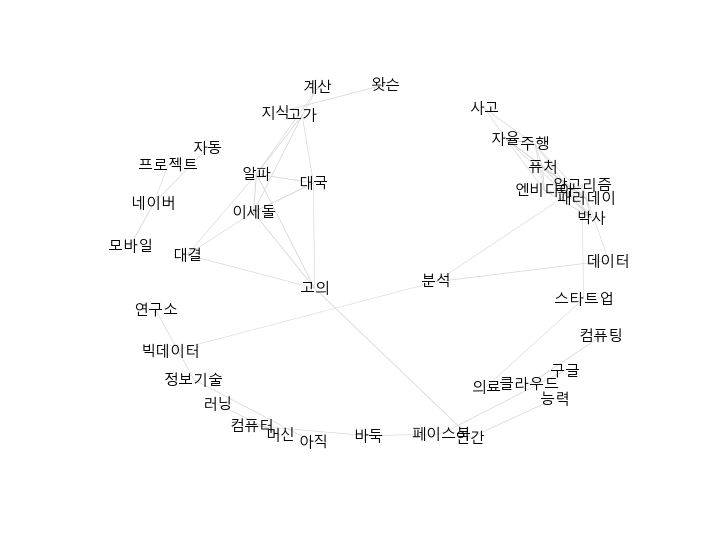

In [212]:
draw_networkx(edges, query_string, remove_slash_end)